In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Model Selection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier # <-- ตัวแทน XGBoost

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ปิดคำเตือน
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

print("Libraries imported.")

Libraries imported.


In [15]:
# --- 2. Load Data ---
# โหลดไฟล์ที่เราเพิ่งสร้างจาก Notebook 04

DATA_DIR = '../data/MODEL_INPUTS/'
FILE_NAME = 'master_features_clustered_v2_pca.csv' # <-- ใช้ไฟล์ที่มี cluster
FILE_PATH = os.path.join(DATA_DIR, FILE_NAME)

try:
    df = pd.read_csv(FILE_PATH)
    print(f"Successfully loaded: {FILE_PATH}")
    print(f"Data shape: {df.shape}")
except FileNotFoundError:
    print(f"!!! ERROR: File not found at {FILE_PATH}")

# ตั้งค่า dcode เป็น index (ถ้า dcode ไม่ใช่ index)
if 'dcode' in df.columns:
    df = df.set_index('dcode')

Successfully loaded: ../data/MODEL_INPUTS/master_features_clustered_v2_pca.csv
Data shape: (50, 64)


In [16]:
# --- 3. Define Features (X) and Target (y) ---

# y (Target) คือ 'cluster' ที่เราต้องการทำนาย (0, 1, 2, 3)
y = df['cluster']

# X (Input Features) คือฟีเจอร์ "ดั้งเดิม" ที่เราใช้ใน Notebook 04
# (เราจะไม่ใช้ PC1-15 ในการเทรนโมเดล Classification เพราะมันตีความยาก)
PROFILE_FEATURES = [
    'AREA', 
    'population', 
    'canal_count', 
    'flood_point_count', 
    'floodgate_count',
    'avg_rain_rainy', 
    'avg_rain_summer', 
    'avg_rain_winter',
    'pump_ready', 
    'pump_repair', 
    'pump_sell', 
    'pump_support',
    'คะแนนรวม', 
    'population_density', 
    'canal_density', 
    'flood_point_density',
    'floodgate_density', 
    'pump_per_capita', 
    'pump_readiness_ratio',
    'group_กรุงธนเหนือ', 
    'group_กรุงธนใต้', 
    'group_กรุงเทพกลาง',
    'group_กรุงเทพตะวันออก', 
    'group_กรุงเทพเหนือ', 
    'group_กรุงเทพใต้',
    'flood_point_per_canal', 
    'risk_score_per_pump'
]

# กรองเอาเฉพาะคอลัมน์ที่มีอยู่
PROFILE_FEATURES = [col for col in PROFILE_FEATURES if col in df.columns]

X = df[PROFILE_FEATURES].copy()

print(f"Input Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

Input Features (X) shape: (50, 27)
Target (y) shape: (50,)


In [17]:
# --- 4. Preprocessing (Log Transform & Scaling) ---
# (เราต้องทำซ้ำเหมือนกับตอนที่เทรน KMeans เพื่อให้ข้อมูลมี Scale เดียวกัน)

# คอลัมน์ที่เบ้ (Skewed) และต้องทำ Log Transform
LOG_COLS = [
    'AREA', 'population', 'canal_count', 'flood_point_count', 'floodgate_count',
    'pump_ready', 'pump_repair', 'pump_sell', 'pump_support', 'คะแนนรวม',
    'population_density', 'canal_density', 'flood_point_density',
    'floodgate_density', 'pump_per_capita',
    'flood_point_per_canal',
    'risk_score_per_pump'
]
LOG_COLS = [col for col in LOG_COLS if col in X.columns]

# 4a. Log Transform
print("Applying Log Transform...")
for col in LOG_COLS:
    X[col] = np.log1p(X[col])

# 4b. Standard Scaling
print("Applying Standard Scaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Preprocessing complete.")

Applying Log Transform...
Applying Standard Scaler...
Preprocessing complete.


In [18]:
# --- 5. Train-Test Split ---
# แบ่งข้อมูล 80% (Train) / 20% (Test)
# ใช้ stratify=y เพราะกลุ่มเราไม่เท่ากัน (26, 5, 8, 11)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y # <-- สำคัญมากสำหรับ Imbalanced data
)

print(f"X_train shape: {X_train.shape} (80%)")
print(f"X_test shape: {X_test.shape} (20%)")
print("\nTraining set distribution:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nTest set distribution:")
print(y_test.value_counts(normalize=True).sort_index())

X_train shape: (40, 27) (80%)
X_test shape: (10, 27) (20%)

Training set distribution:
cluster
0    0.525
1    0.100
2    0.150
3    0.225
Name: proportion, dtype: float64

Test set distribution:
cluster
0    0.5
1    0.1
2    0.2
3    0.2
Name: proportion, dtype: float64


In [19]:
# --- 6. Model 1: Logistic Regression ---

print("="*50)
print("Training Model 1: Logistic Regression (Baseline)")
print("="*50)

# 1. Initialize
model_lr = LogisticRegression(multi_class='ovr', random_state=42, max_iter=1000)

# 2. Fit (Train)
model_lr.fit(X_train, y_train)

# 3. Predict
y_pred_lr = model_lr.predict(X_test)

# 4. Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

# เก็บผลลัพธ์
results = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'F1-Score (Weighted)': classification_report(y_test, y_pred_lr, output_dict=True)['weighted avg']['f1-score']
    }
}

Training Model 1: Logistic Regression (Baseline)
Accuracy: 1.0000

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [20]:
# --- 7. Model 2: Random Forest ---

print("="*50)
print("Training Model 2: Random Forest Classifier")
print("="*50)

# 1. Initialize
model_rf = RandomForestClassifier(random_state=42, n_estimators=100)

# 2. Fit (Train)
model_rf.fit(X_train, y_train)

# 3. Predict
y_pred_rf = model_rf.predict(X_test)

# 4. Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# เก็บผลลัพธ์
results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'F1-Score (Weighted)': classification_report(y_test, y_pred_rf, output_dict=True)['weighted avg']['f1-score']
}

Training Model 2: Random Forest Classifier
Accuracy: 1.0000

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [21]:
# --- 8. Model 3: HistGradientBoosting Classifier (Advanced) ---

print("="*50)
print("Training Model 3: HistGradientBoosting Classifier")
print("="*50)

# 1. Initialize
model_hgb = HistGradientBoostingClassifier(random_state=42)

# 2. Fit (Train)
model_hgb.fit(X_train, y_train)

# 3. Predict
y_pred_hgb = model_hgb.predict(X_test)

# 4. Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred_hgb):.4f}")
print("\nClassification Report (HistGradientBoosting):")
print(classification_report(y_test, y_pred_hgb))

# เก็บผลลัพธ์
results['HistGradientBoosting'] = {
    'Accuracy': accuracy_score(y_test, y_pred_hgb),
    'F1-Score (Weighted)': classification_report(y_test, y_pred_hgb, output_dict=True)['weighted avg']['f1-score']
}

Training Model 3: HistGradientBoosting Classifier
Accuracy: 0.8000

Classification Report (HistGradientBoosting):
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         2

    accuracy                           0.80        10
   macro avg       0.68      0.75      0.71        10
weighted avg       0.66      0.80      0.72        10



In [22]:
# --- 9. Model Comparison ---

print("="*50)
print("--- Model Comparison Results ---")
print("="*50)

results_df = pd.DataFrame(results).T.sort_values(by='F1-Score (Weighted)', ascending=False)
display(results_df)

# (เราจะเลือกโมเดลที่ F1-Score (Weighted) สูงที่สุด)

--- Model Comparison Results ---


,Accuracy,F1-Score (Weighted)
Logistic Regression,1.0,1.000000
Random Forest,1.0,1.000000
HistGradientBoosting,0.8,0.716667



--- Feature Importance (จาก Random Forest) ---


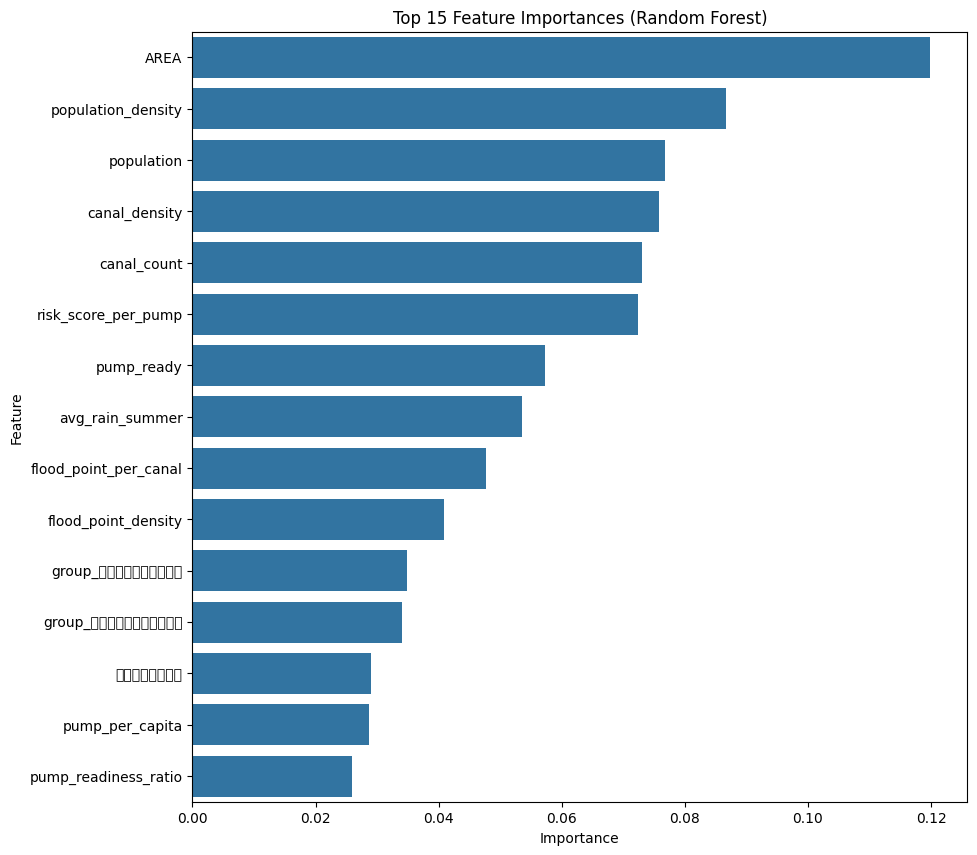

In [23]:
# --- 10. Feature Importance ---
# (มาดูกันว่าฟีเจอร์ไหนสำคัญที่สุดในการทำนายกลุ่ม)

print("\n--- Feature Importance (จาก Random Forest) ---")
# สร้าง DataFrame สำหรับ Feature Importance
feature_importance_rf = pd.DataFrame({
    'Feature': PROFILE_FEATURES,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# พล็อต
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_rf.head(15)) # เอาแค่ 15 อันดับแรก
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

# (เนื่องจาก HistGradientBoosting การดึง Feature Importance จะซับซ้อนกว่า 
#  เราจะใช้ Random Forest เป็นตัวแทนในการวิเคราะห์ปัจจัยสำคัญครับ)